A notebook for generating the final results for a fully cross-validated transfer analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import pathlib
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np

from janelia_core.stats.regression import r_squared
from janelia_core.utils.file_system import get_immediate_subfolders

In [3]:
%matplotlib notebook

## Parameters go here

In [4]:
# A list of of base_folders with the results of different analyses.  A single analysis consists of 
# runing the full cross-validated results with multiple amounts of training data for models fit
# both individually and combined, with a *single* set of parameters.  In this convention, we could 
# run different analyses using different numbers of hypercubes in the prior, for example, and then compare results. 

base_folders = [r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnlr/same_cond_transfer_analysis/v19']

# The names of files holding post-processed results for each type of analysis
results_files = ['pp_test_results.pkl']

# Subjects we want to evaluate performance on
eval_subjs = [8, 10, 11]

subj_clrs = np.asarray([[1.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0], 
                        [0.0, 0.0, 1.0]])

# Training quantities we want to evaluate performance on
tq_strings = ['fold_str_base_14_tgt_1', 
              'fold_str_base_14_tgt_2',
              'fold_str_base_14_tgt_4',
              'fold_str_base_14_tgt_8',
              'fold_str_base_14_tgt_14']
tq_fracs = np.asarray([1.0/14, 
                       2.0/14, 
                       4.0/14,
                       8.0/14,
                       14.0/14.0])

## Define helper functions here

In [5]:
def get_analysis_results(base_folder, results_file, fit_type: str = 'ip', data_type: str = 'test'):
    training_quantity_folders = get_immediate_subfolders(base_folder)
    tq_rs = dict()
    for tq_folder in training_quantity_folders:
        tq_folder_path = pathlib.Path(base_folder) / tq_folder
        fold_folders = get_immediate_subfolders(tq_folder_path)
        n_folds = len(fold_folders)
        fold_rs = dict()
        for fold_folder in fold_folders:
            cur_fold = int(re.match('.*_(\d*)', fold_folder)[1])
            fold_folder_path = pathlib.Path(tq_folder_path) / fold_folder
            subj_folders = get_immediate_subfolders(fold_folder_path)
            n_subjs = len(subj_folders)
            subj_rs = dict()
            for subj_folder in subj_folders:
                subj_folder_path = pathlib.Path(fold_folder_path) / subj_folder
                type_folders = get_immediate_subfolders(subj_folder_path)
                eval_subj = int(re.match('.*_(\d*)', subj_folder)[1])
                type_rs = dict()
                for type_folder in type_folders:
                    cur_type = type_folder
                    type_folder_path = pathlib.Path(subj_folder_path) / type_folder
                    results_file_path = type_folder_path / results_file
                    with open(results_file_path, 'rb') as f: 
                        rs = pickle.load(f)
                        r_sq = r_squared(rs[fit_type]['preds'][eval_subj][data_type]['y'], 
                                              rs[fit_type]['preds'][eval_subj][data_type]['y_hat'])
                        type_rs[cur_type] = r_sq
                subj_rs[eval_subj] = type_rs
            fold_rs[cur_fold] = subj_rs
        tq_rs[tq_folder] = fold_rs
    return tq_rs

In [6]:
def get_subj_rs(rs, subj, fit_type: str = 'ind'):
    """ Gets average performance for a single subject, for each for fold, for a single fit type 
        for a single training quantity. """
    n_folds = len(rs)
    folds = np.sort(np.asarray(list(rs.keys())))
    
    fold_rs = np.zeros(n_folds)
    for f_i, f_n in enumerate(folds):
        fold_rs[f_i] = np.mean(rs[f_n][subj][fit_type])
    return fold_rs

In [7]:
def get_avg_fit_type_rs_for_fixed_training_quantity(rs, subjs, fit_type: str = 'ind'):
    """ Gets average and standard error of performance across folds for multiple subjects for a single fit type
        and for a single training quantity."""
    n_subjs = len(subjs)
    mn_rs = np.zeros(n_subjs)
    std_er_rs = np.zeros(n_subjs)
    for s_i, subj in enumerate(subjs):
        fold_rs = get_subj_rs(rs, subj=subj, fit_type=fit_type)
        mn_rs[s_i] = np.mean(fold_rs)
        std_er_rs[s_i] = np.std(fold_rs)/np.sqrt(len(fold_rs))
    return [mn_rs, std_er_rs]
        
        

In [8]:
def get_fit_type_rs(rs, train_quantity_keys, subjs, fit_type: str = 'ind'):
    n_train_quantity_keys = len(train_quantity_keys)
    n_subjs = len(subjs)
    mn_rs = np.zeros([n_train_quantity_keys, n_subjs])
    std_er_rs = np.zeros([n_train_quantity_keys, n_subjs])
    for tq_i, tq_key in enumerate(train_quantity_keys):
        mn_rs[tq_i, :],  std_er_rs[tq_i, :] = get_avg_fit_type_rs_for_fixed_training_quantity(rs[tq_key], subjs, fit_type)
    return mn_rs, std_er_rs

## Get results

In [9]:
c_rs = get_analysis_results(base_folders[0], results_files[0])

In [10]:
comb_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='comb')
ind_rs = get_fit_type_rs(c_rs, tq_strings, subjs=eval_subjs, fit_type='ind')

## Plot results

<IPython.core.display.Javascript object>


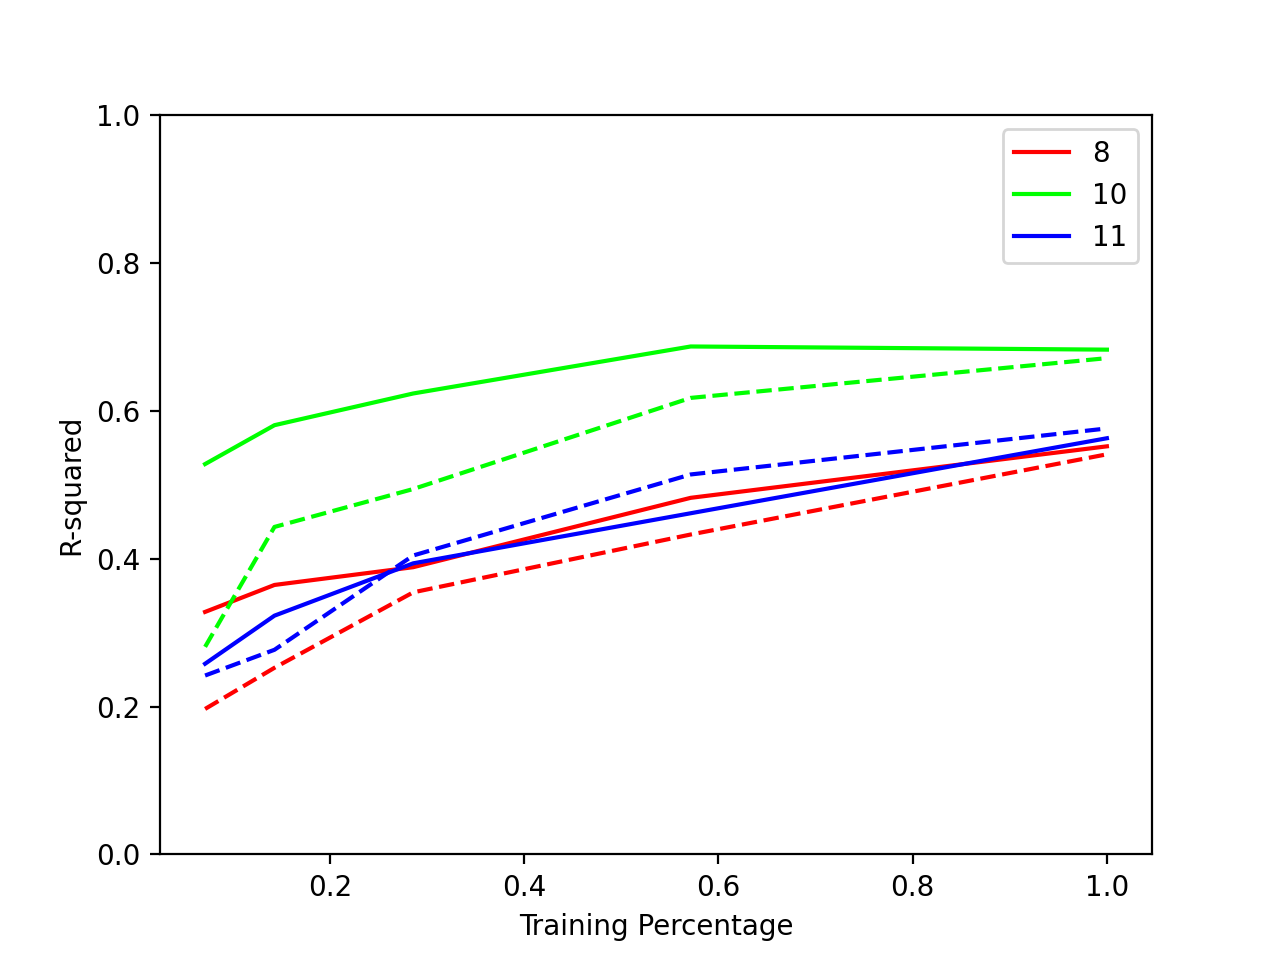

(0.0, 1.0)

In [11]:
plt.figure()
ax = plt.subplot(1,1,1)
for s_i, subj in enumerate(eval_subjs):
    plt.plot(tq_fracs, comb_rs[0][:, s_i], '-', color=subj_clrs[s_i])
plt.legend(eval_subjs)
plt.xlabel('Training Percentage')
plt.ylabel('R-squared')

for s_i, subj in enumerate(eval_subjs):
    plt.plot(tq_fracs, ind_rs[0][:, s_i], '--', color=subj_clrs[s_i])
ax.set_ylim([0, 1])


## Look at example predictions

In [12]:
comb_rs

(array([[0.32802985, 0.52804442, 0.25791701],
        [0.36450382, 0.58063437, 0.32296313],
        [0.3885488 , 0.62354406, 0.39376282],
        [0.48237843, 0.68713059, 0.461515  ],
        [0.5520431 , 0.68284168, 0.56298554]]),
 array([[0.01915766, 0.00877276, 0.04554347],
        [0.00578117, 0.03889942, 0.07524645],
        [0.01719284, 0.03255736, 0.03878326],
        [0.00536192, 0.00155067, 0.04991428],
        [0.00162204, 0.03637378, 0.0336151 ]]))

In [13]:
ind_rs

(array([[0.1967656 , 0.28077832, 0.24198708],
        [0.2524439 , 0.44300749, 0.27679587],
        [0.35452347, 0.49427039, 0.40435168],
        [0.43276955, 0.61756525, 0.51398695],
        [0.541255  , 0.67134366, 0.57622288]]),
 array([[0.01966241, 0.03227712, 0.01218996],
        [0.00757015, 0.01789545, 0.04828242],
        [0.01760194, 0.00374748, 0.0139273 ],
        [0.0049696 , 0.01177307, 0.02146499],
        [0.00688549, 0.03263868, 0.02482028]]))

In [14]:
c_rs['fold_str_base_14_tgt_14']

{1: {8: {'ind': array([0.43577206, 0.6167628 ], dtype=float32),
   'comb': array([0.46733105, 0.64439565], dtype=float32)},
  10: {'ind': array([0.7870642 , 0.65547526], dtype=float32),
   'comb': array([0.8086289, 0.6671144], dtype=float32)},
  11: {'ind': array([0.5204984 , 0.51054186], dtype=float32),
   'comb': array([0.4759344 , 0.51210713], dtype=float32)}},
 2: {8: {'ind': array([0.60872734, 0.50216776], dtype=float32),
   'comb': array([0.5794536 , 0.52270293], dtype=float32)},
  10: {'ind': array([0.5652089, 0.6193985], dtype=float32),
   'comb': array([0.7160325, 0.7159883], dtype=float32)},
  11: {'ind': array([0.6453469 , 0.57366264], dtype=float32),
   'comb': array([0.58673275, 0.53028566], dtype=float32)}},
 0: {8: {'ind': array([0.55029696, 0.533803  ], dtype=float32),
   'comb': array([0.59481597, 0.50355935], dtype=float32)},
  10: {'ind': array([0.68970174, 0.71121335], dtype=float32),
   'comb': array([0.78361094, 0.4056751 ], dtype=float32)},
  11: {'ind': array([0

In [15]:
c_rs['fold_str_base_14_tgt_14']

{1: {8: {'ind': array([0.43577206, 0.6167628 ], dtype=float32),
   'comb': array([0.46733105, 0.64439565], dtype=float32)},
  10: {'ind': array([0.7870642 , 0.65547526], dtype=float32),
   'comb': array([0.8086289, 0.6671144], dtype=float32)},
  11: {'ind': array([0.5204984 , 0.51054186], dtype=float32),
   'comb': array([0.4759344 , 0.51210713], dtype=float32)}},
 2: {8: {'ind': array([0.60872734, 0.50216776], dtype=float32),
   'comb': array([0.5794536 , 0.52270293], dtype=float32)},
  10: {'ind': array([0.5652089, 0.6193985], dtype=float32),
   'comb': array([0.7160325, 0.7159883], dtype=float32)},
  11: {'ind': array([0.6453469 , 0.57366264], dtype=float32),
   'comb': array([0.58673275, 0.53028566], dtype=float32)}},
 0: {8: {'ind': array([0.55029696, 0.533803  ], dtype=float32),
   'comb': array([0.59481597, 0.50355935], dtype=float32)},
  10: {'ind': array([0.68970174, 0.71121335], dtype=float32),
   'comb': array([0.78361094, 0.4056751 ], dtype=float32)},
  11: {'ind': array([0